In [10]:
rm(list=ls())
options(warn = -1)

In [11]:
R_P_matrix=readRDS("./Data/R_P_matrix.rds")
R_P_matrix_pcor=readRDS("./Data/R_P_matrix_cor.rds")

In [12]:
GWAS=read.csv("./Data/gwasATLAS_v20191115.csv")

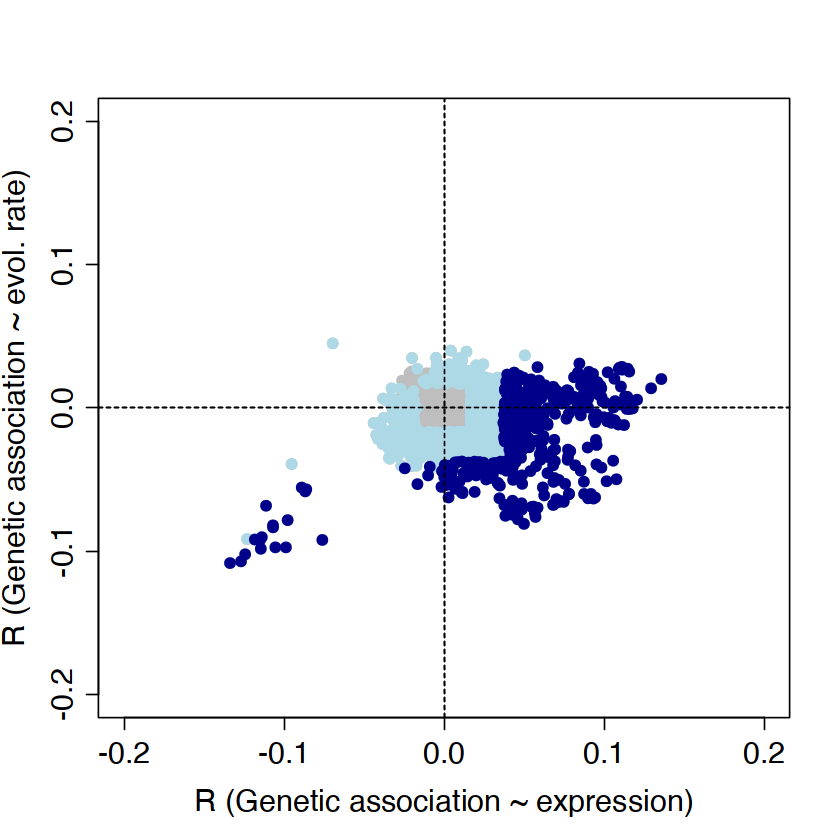

In [13]:
plot(R_P_matrix_pcor$GTEX_R, R_P_matrix_pcor$ER_R, ylim=c(-0.2,0.2), xlim=c(-0.2,0.2), col="gray", pch=19, 
    xlab="R (Genetic association ~ expression)", ylab="R (Genetic association ~ evol. rate)", cex.lab=1.5, cex.axis=1.5)
abline(v=0, lty=2)
abline(h=0, lty=2)


index_1=which(R_P_matrix_pcor$GTEX_P < 0.05)
index_2=which(R_P_matrix_pcor$ER_P < 0.05)
index_sig=unique(c(index_1, index_2))
R_P_matrix_sig=R_P_matrix_pcor[index_sig,]
R_P_matrix_sig=R_P_matrix_pcor[index_sig,]
lines(R_P_matrix_sig$GTEX_R, R_P_matrix_sig$ER_R, ylim=c(-0.2,0.2), xlim=c(-0.2,0.2), pch=19, 
    col="lightblue", cex.lab=1.5, cex.axis=1.5, type="p")



index_1=which(R_P_matrix_pcor$GTEX_P < 0.05/4576)
index_2=which(R_P_matrix_pcor$ER_P < 0.05/4576)
index_sig=unique(c(index_1, index_2))
R_P_matrix_sig=R_P_matrix_pcor[index_sig,]
R_P_matrix_sig=R_P_matrix_pcor[index_sig,]
lines(R_P_matrix_sig$GTEX_R, R_P_matrix_sig$ER_R, ylim=c(-0.2,0.2), xlim=c(-0.2,0.2), pch=19, 
    col="darkblue", cex.lab=1.5, cex.axis=1.5, type="p")

#text(R_P_matrix_sig$GTEX_R, R_P_matrix_sig$ER_R, rownames(R_P_matrix_sig))
                 
abline(v=0, lty=2)
abline(h=0, lty=2)


The following categorical variables are over-represented in the small vector:
Activities, Cardiovascular, Cognitive, Dermatological, Environment, Gastrointestinal, Metabolic, Neurological, Nutritional, Psychiatric, Skeletal

,Trait,Prob
,<chr>,<dbl>
1,Metabolic,35
2,Psychiatric,15
3,Neurological,13
4,Dermatological,3
5,Cardiovascular,5
6,Activities,4
7,Cognitive,2
8,Skeletal,5
9,Environment,2


[1] 0.0007041182

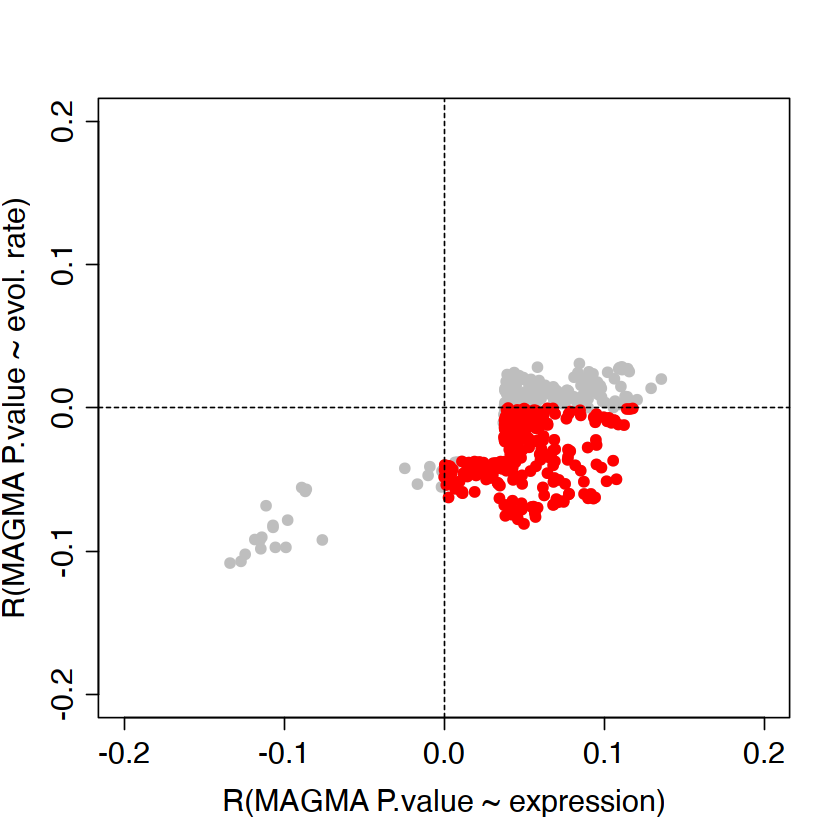

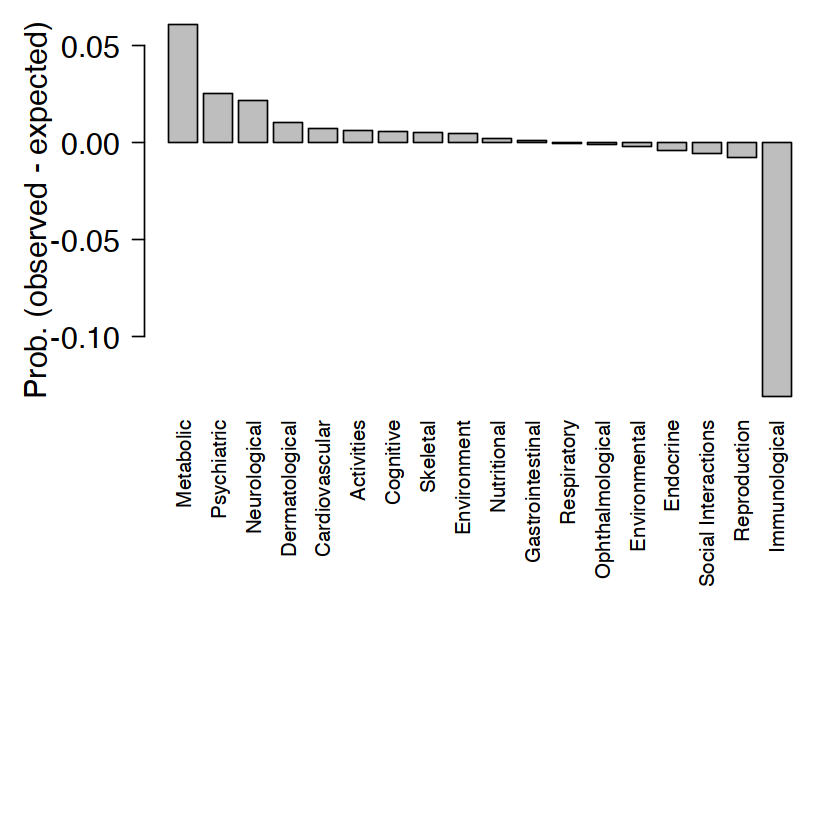

In [14]:
#### Quadrant A

## Calculate the Distance of each trait to origin
Trait_Distance=sqrt( (R_P_matrix_sig$GTEX_R)^2 + ((R_P_matrix_sig$ER_R)^2) )
names(Trait_Distance)=rownames(R_P_matrix_sig)


### Choose top 100 of traits within each quandrant
n_top_traits=300

map_index=which( (R_P_matrix_sig$GTEX_R > 0) &  (R_P_matrix_sig$ER_R < 0))
top_traits=as.numeric(names(sort(Trait_Distance[match(as.numeric(rownames(R_P_matrix_sig[map_index,])), names(Trait_Distance))], decreasing = TRUE)[1:n_top_traits]))


## Check Visually
plot(R_P_matrix_sig$GTEX_R, R_P_matrix_sig$ER_R, ylim=c(-0.2,0.2), xlim=c(-0.2,0.2), col="gray", pch=19, 
    xlab="R(MAGMA P.value ~ expression)", ylab="R(MAGMA P.value ~ evol. rate)", cex.lab=1.5, cex.axis=1.5)

map_index2=match(top_traits, as.numeric(rownames(R_P_matrix_sig)))

lines(R_P_matrix_sig$GTEX_R[map_index2], R_P_matrix_sig$ER_R[map_index2], ylim=c(-0.2,0.2), col="red", pch=19, type="p")
abline(h=0, lty=2)
abline(v=0, lty=2)


## Large vextor containing all traits where p-val associates significantly with dN/dS or GTEX expression
large_vector=GWAS$Domain[as.numeric(rownames(R_P_matrix_sig))]

## small vector: the ones selected in each quadrant
small_vector=GWAS$Domain[top_traits]

# Count the number of occurrences of each categorical variable in the small vector
small_vector_counts <- table(small_vector)
present_groups=names(small_vector_counts)

# Create a vector of expected proportions based on the large vector
large_vector_counts <- table(large_vector)
large_vector_counts=large_vector_counts[match(present_groups, names(large_vector_counts))]

expected_props <- large_vector_counts/sum(large_vector_counts)


# Remove any categories with 0 counts and undefined
small_vector_counts <- small_vector_counts[expected_props != 0]
small_vector_counts=small_vector_counts[which(!is.na(names(small_vector_counts)))]



# Perform a chi-squared test
test_result <- chisq.test(small_vector_counts, p = expected_props)

# Extract the test statistic and p-value
test_statistic <- test_result$statistic
p_value <- test_result$p.value

# Determine which categorical variables are over-represented
if (test_statistic > 0 && p_value < 0.05) {
  # Calculate the observed proportions of each category in the small vector
  observed_props <- small_vector_counts/sum(small_vector_counts)
  
  # Find the categories with observed proportions greater than expected proportions
  over_represented_categories <- names(observed_props[observed_props > expected_props])
  
  cat("The following categorical variables are over-represented in the small vector:\n")
  cat(paste(over_represented_categories, collapse = ", "))
} else if (test_statistic < 0 && p_value < 0.0001) {
  cat("At least one categorical variable is under-represented in the small vector.\n")
} else {
  cat("No categorical variable is over-represented or under-represented in the small vector.\n")
}



data <- data.frame(name = names(observed_props -  expected_props), prob = observed_props -  expected_props)
data=data[,-2]
colnames(data)=c("Trait", "Prob")

data <- data[order(data$Prob, decreasing = TRUE),]
rownames(data)=seq(1,dim(data)[1])
par(mfrow = c(2,1))
par(mar = c(1,6,1,1))
barplot(data$Prob, names.arg = data$Trait, las=2, cex.lab=1.5, cex.axis=1.5, ylab="Prob. (observed - expected)", 
       mgp=c(4,1,0))

percentage=round(table(small_vector)*100/sum(table(small_vector)))
data$Prob[match(names(percentage), data$Trait)]=percentage
data
data_A=data

p_value

The following categorical variables are over-represented in the small vector:
Body Structures, Connective Tissue, Environmental, Immunological, Mortality, Ophthalmological

,Trait,Prob
,<chr>,<dbl>
1,Immunological,49
2,Connective Tissue,2
3,Mortality,1
4,Environmental,3
5,Ophthalmological,1
6,Body Structures,1
7,Respiratory,3
8,Endocrine,1
9,Skeletal,4


[1] 9.170447e-16

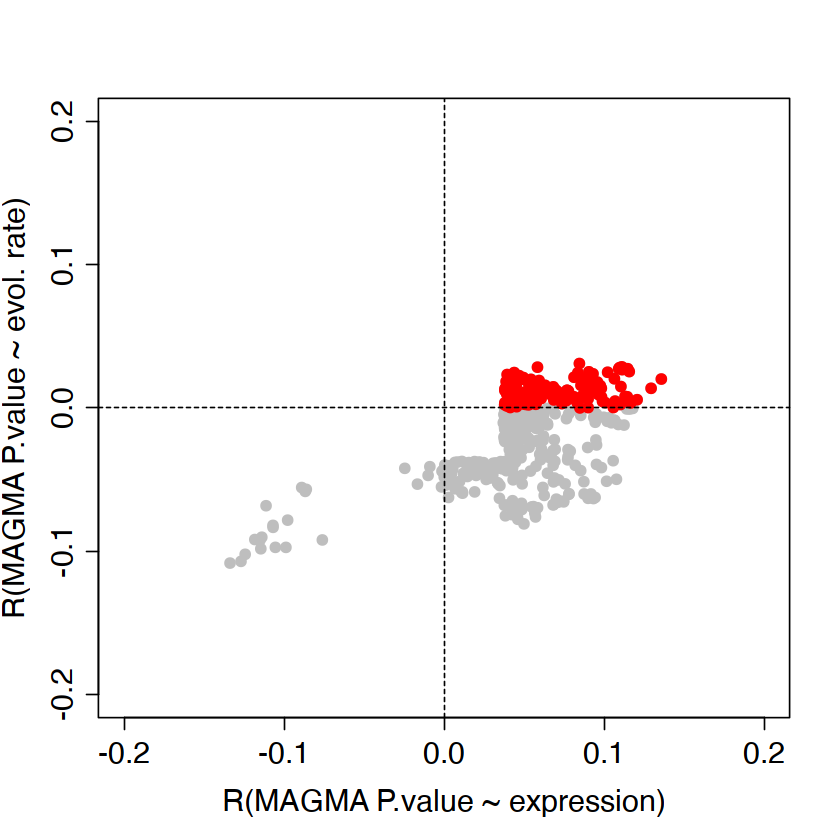

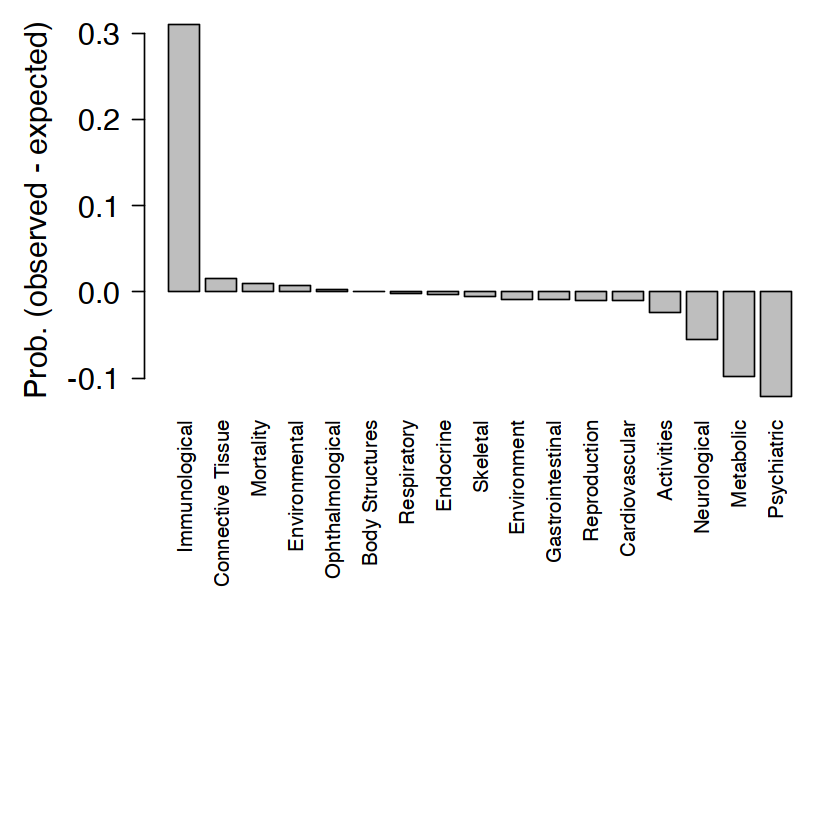

In [15]:
#### Quadrant B

## Calculate the Distance of each trait to origin

Trait_Distance=sqrt( (R_P_matrix_sig$GTEX_R)^2 + ((R_P_matrix_sig$ER_R)^2) )
names(Trait_Distance)=rownames(R_P_matrix_sig)


### Choose top 100 of traits within each quandrant
n_top_traits=250

map_index=which( (R_P_matrix_sig$GTEX_R > 0) &  (R_P_matrix_sig$ER_R > 0))
top_traits=as.numeric(names(sort(Trait_Distance[match(as.numeric(rownames(R_P_matrix_sig[map_index,])), names(Trait_Distance))], decreasing = TRUE)[1:n_top_traits]))


## Check Visually
plot(R_P_matrix_sig$GTEX_R, R_P_matrix_sig$ER_R, ylim=c(-0.2,0.2), xlim=c(-0.2,0.2), col="gray", pch=19, 
    xlab="R(MAGMA P.value ~ expression)", ylab="R(MAGMA P.value ~ evol. rate)", cex.lab=1.5, cex.axis=1.5)

map_index2=match(top_traits, as.numeric(rownames(R_P_matrix_sig)))

lines(R_P_matrix_sig$GTEX_R[map_index2], R_P_matrix_sig$ER_R[map_index2], ylim=c(-0.2,0.2), col="red", pch=19, type="p")
abline(h=0, lty=2)
abline(v=0, lty=2)


## Large vextor containing all traits where p-val associates significantly with dN/dS or GTEX expression
large_vector=GWAS$Domain[as.numeric(rownames(R_P_matrix_sig))]

## small vector: the ones selected in each quadrant
small_vector=GWAS$Domain[top_traits]

# Count the number of occurrences of each categorical variable in the small vector
small_vector_counts <- table(small_vector)
present_groups=names(small_vector_counts)

# Create a vector of expected proportions based on the large vector
large_vector_counts <- table(large_vector)
large_vector_counts=large_vector_counts[match(present_groups, names(large_vector_counts))]

expected_props <- large_vector_counts/sum(large_vector_counts)


# Remove any categories with 0 counts and undefined
small_vector_counts <- small_vector_counts[expected_props != 0]
small_vector_counts=small_vector_counts[which(!is.na(names(small_vector_counts)))]



# Perform a chi-squared test
test_result <- chisq.test(small_vector_counts, p = expected_props)

# Extract the test statistic and p-value
test_statistic <- test_result$statistic
p_value <- test_result$p.value

# Determine which categorical variables are over-represented
if (test_statistic > 0 && p_value < 0.05) {
  # Calculate the observed proportions of each category in the small vector
  observed_props <- small_vector_counts/sum(small_vector_counts)
  
  # Find the categories with observed proportions greater than expected proportions
  over_represented_categories <- names(observed_props[observed_props > expected_props])
  
  cat("The following categorical variables are over-represented in the small vector:\n")
  cat(paste(over_represented_categories, collapse = ", "))
} else if (test_statistic < 0 && p_value < 0.0001) {
  cat("At least one categorical variable is under-represented in the small vector.\n")
} else {
  cat("No categorical variable is over-represented or under-represented in the small vector.\n")
}



data <- data.frame(name = names(observed_props -  expected_props), prob = observed_props -  expected_props)
data=data[,-2]
colnames(data)=c("Trait", "Prob")

data <- data[order(data$Prob, decreasing = TRUE),]
rownames(data)=seq(1,dim(data)[1])
par(mfrow = c(2,1))
par(mar = c(1,6,1,1))
barplot(data$Prob, names.arg = data$Trait, las=2, cex.lab=1.5, cex.axis=1.5, ylab="Prob. (observed - expected)", 
       mgp=c(4,1,0))

percentage=round(table(small_vector)*100/sum(table(small_vector)))
data$Prob[match(names(percentage), data$Trait)]=percentage
data
data_B=data

p_value

The following categorical variables are over-represented in the small vector:
Body Structures, Neoplasms, Reproduction, Social Interactions

,Trait,Prob
,<chr>,<dbl>
1,Neoplasms,12
2,Social Interactions,12
3,Body Structures,8
4,Reproduction,16
5,Endocrine,4
6,Respiratory,4
7,Psychiatric,44


[1] 0.01162998

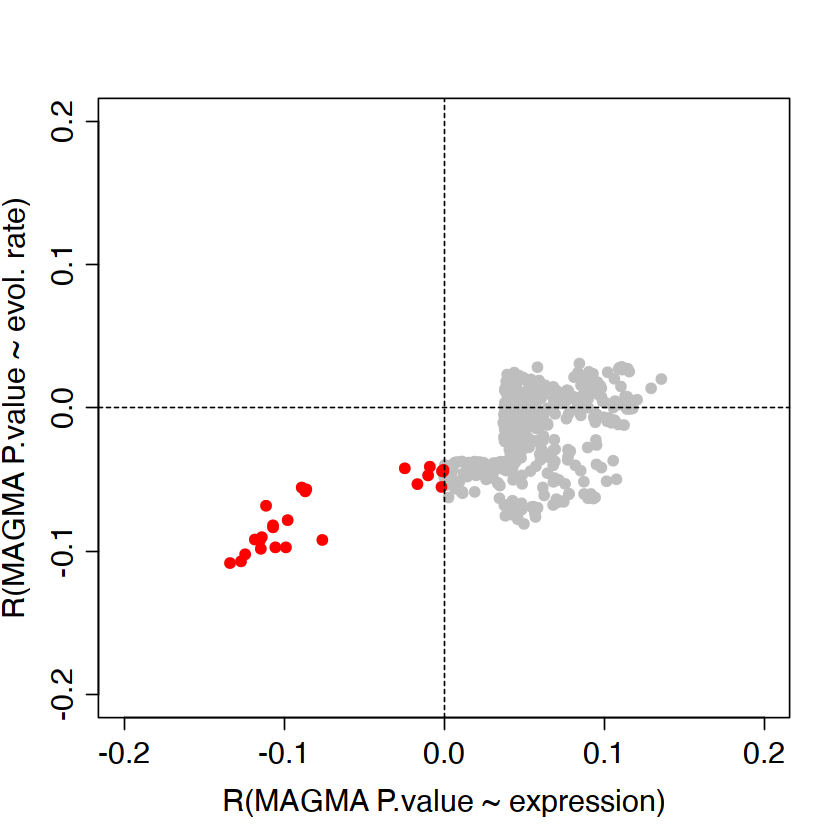

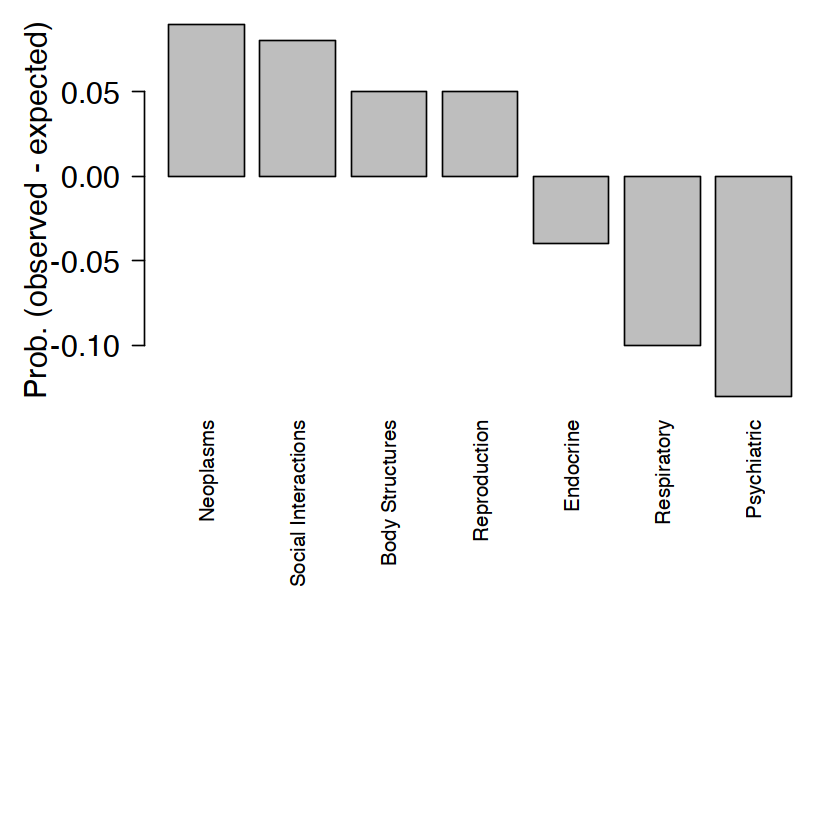

In [16]:
#### Quadrant C

## Calculate the Distance of each trait to origin

Trait_Distance=sqrt( (R_P_matrix_sig$GTEX_R)^2 + ((R_P_matrix_sig$ER_R)^2) )
names(Trait_Distance)=rownames(R_P_matrix_sig)


### Choose top 100 of traits within each quandrant
n_top_traits=250

map_index=which( (R_P_matrix_sig$GTEX_R < 0) &  (R_P_matrix_sig$ER_R < 0))
top_traits=as.numeric(names(sort(Trait_Distance[match(as.numeric(rownames(R_P_matrix_sig[map_index,])), names(Trait_Distance))], decreasing = TRUE)[1:n_top_traits]))


## Check Visually
plot(R_P_matrix_sig$GTEX_R, R_P_matrix_sig$ER_R, ylim=c(-0.2,0.2), xlim=c(-0.2,0.2), col="gray", pch=19, 
    xlab="R(MAGMA P.value ~ expression)", ylab="R(MAGMA P.value ~ evol. rate)", cex.lab=1.5, cex.axis=1.5)

map_index2=match(top_traits, as.numeric(rownames(R_P_matrix_sig)))

lines(R_P_matrix_sig$GTEX_R[map_index2], R_P_matrix_sig$ER_R[map_index2], ylim=c(-0.2,0.2), col="red", pch=19, type="p")
abline(h=0, lty=2)
abline(v=0, lty=2)


## Large vextor containing all traits where p-val associates significantly with dN/dS or GTEX expression
large_vector=GWAS$Domain[as.numeric(rownames(R_P_matrix_sig))]

## small vector: the ones selected in each quadrant
small_vector=GWAS$Domain[top_traits]

# Count the number of occurrences of each categorical variable in the small vector
small_vector_counts <- table(small_vector)
present_groups=names(small_vector_counts)

# Create a vector of expected proportions based on the large vector
large_vector_counts <- table(large_vector)
large_vector_counts=large_vector_counts[match(present_groups, names(large_vector_counts))]

expected_props <- large_vector_counts/sum(large_vector_counts)


# Remove any categories with 0 counts and undefined
small_vector_counts <- small_vector_counts[expected_props != 0]
small_vector_counts=small_vector_counts[which(!is.na(names(small_vector_counts)))]



# Perform a chi-squared test
test_result <- chisq.test(small_vector_counts, p = expected_props)

# Extract the test statistic and p-value
test_statistic <- test_result$statistic
p_value <- test_result$p.value

# Determine which categorical variables are over-represented
if (test_statistic > 0 && p_value < 0.05) {
  # Calculate the observed proportions of each category in the small vector
  observed_props <- small_vector_counts/sum(small_vector_counts)
  
  # Find the categories with observed proportions greater than expected proportions
  over_represented_categories <- names(observed_props[observed_props > expected_props])
  
  cat("The following categorical variables are over-represented in the small vector:\n")
  cat(paste(over_represented_categories, collapse = ", "))
} else if (test_statistic < 0 && p_value < 0.0001) {
  cat("At least one categorical variable is under-represented in the small vector.\n")
} else {
  cat("No categorical variable is over-represented or under-represented in the small vector.\n")
}



data <- data.frame(name = names(observed_props -  expected_props), prob = observed_props -  expected_props)
data=data[,-2]
colnames(data)=c("Trait", "Prob")

data <- data[order(data$Prob, decreasing = TRUE),]
rownames(data)=seq(1,dim(data)[1])
par(mfrow = c(2,1))
par(mar = c(1,6,1,1))
barplot(data$Prob, names.arg = data$Trait, las=2, cex.lab=1.5, cex.axis=1.5, ylab="Prob. (observed - expected)", 
       mgp=c(4,1,0))

percentage=round(table(small_vector)*100/sum(table(small_vector)))
data$Prob[match(names(percentage), data$Trait)]=percentage
data
data_C=data
p_value

In [17]:
library(dplyr)
library(ggplot2)

Traits=unique(c(data_A$Trait, data_B$Trait, data_C$Trait))

final_matrix=matrix(NA, nrow = length(Traits), ncol = 3)
rownames(final_matrix)=Traits



final_matrix[,1]=data_A$Prob[match(Traits, data_A$Trait)]
final_matrix[,2]=data_A$Prob[match(Traits, data_B$Trait)]
final_matrix[,3]=data_A$Prob[match(Traits, data_C$Trait)]

colnames(final_matrix)=c("Quad_A", "Quad_B", "Quad_C")

final_matrix


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,Quad_A,Quad_B,Quad_C
Metabolic,35,0,NA
Psychiatric,15,2,2
Neurological,13,1,NA
Dermatological,3,NA,NA
Cardiovascular,5,0,NA
Activities,4,2,NA
Cognitive,2,NA,NA
Skeletal,5,2,NA
Environment,2,1,NA
Nutritional,1,NA,NA


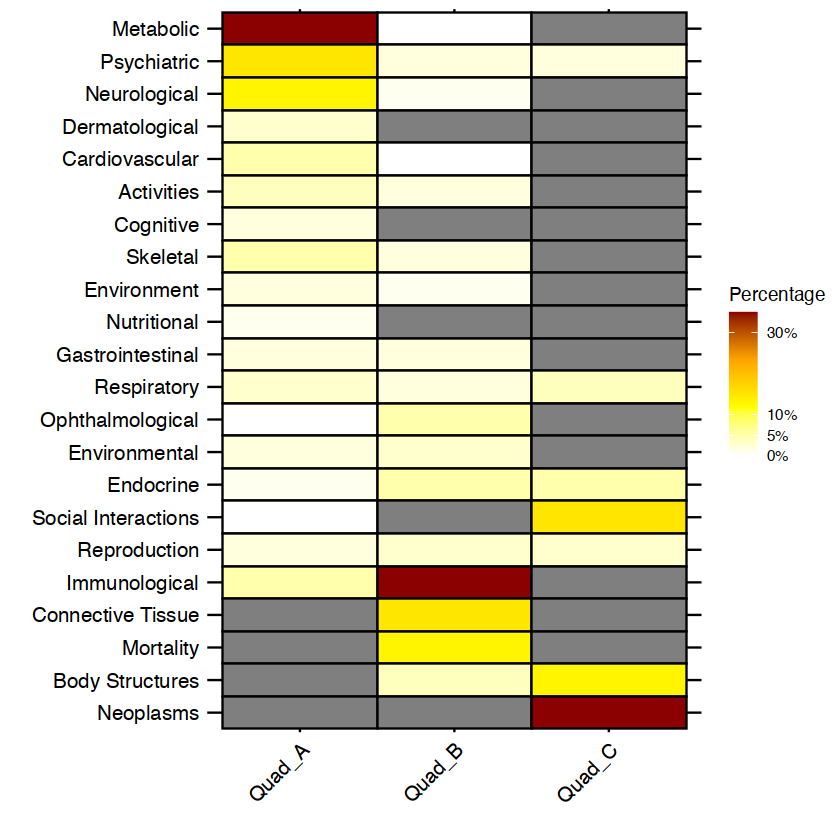

In [18]:
# Assuming your matrix is named 'p_values_matrix'
library(ggplot2)
library(reshape2)
library(scales)

# Convert the matrix to a data frame
data <- melt(final_matrix)

# Define the breaks for the color scale
color_breaks <- c(0, 5, 10, 30, 50, 100)

# Define the colors for the manual color scale
color_values <- c("white", "yellow", "orange", "darkred")

# Generate the heatmap with separated cells and custom color key
ggplot(data, aes(x = Var2, y = Var1, fill = value)) +
  geom_tile(color = "black", size = 0.5) +
  scale_fill_gradientn(name = "Percentage", 
                       breaks = color_breaks,
                       colors = color_values,
                       labels = percent_format(scale = 1)) +
  labs(x = "", y = "", fill = "Percentage") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1),
        axis.text.x.bottom = element_text(size = 12, color = "black"),
        axis.text.y.left = element_text(size = 12, color = "black"),
        panel.grid.major = element_line(color = "black", linewidth = 0.5),
        panel.grid.minor = element_blank()) +
  # Reverse the order of rows on the plot
  scale_y_discrete(limits = rev(levels(data$Var1)))




